# Analyses on idealized perturbation experiments

In [1]:
import glob
import os
import io
import numpy as np
import xarray as xr
# import gcsfs

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as patches
import cartopy.crs as ccrs
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
import cartopy.feature as cfeature
import matplotlib.patches as mpatches # add polygon
from matplotlib.transforms import Bbox

## Part1: NDJF climatology run

In [2]:
fpath_climo = '../output/idealized_T/'
fname_climo = 'output_NDJF-climo_1980-2023_day0-60_1-4-deg-model.nc'
ds = xr.open_dataset(fpath_climo + fname_climo)

z500_climo = ds.geopotential.sel(level=500) / 9.8
t1000_climo = ds.temperature.sel(level=1000)

day 0


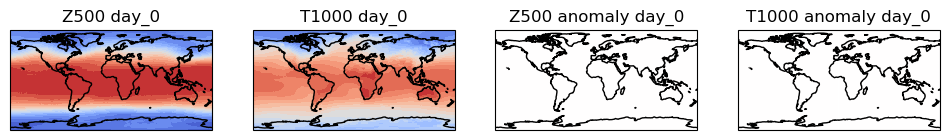

day 1


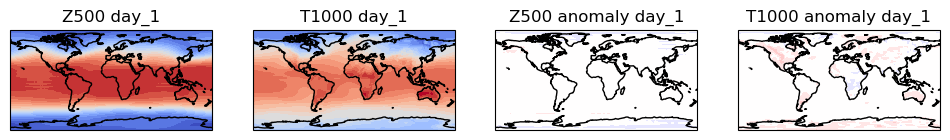

day 2


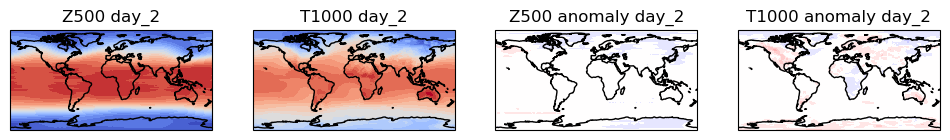

day 3


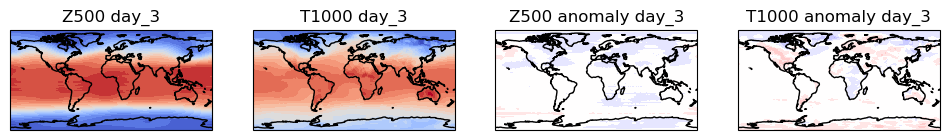

day 4


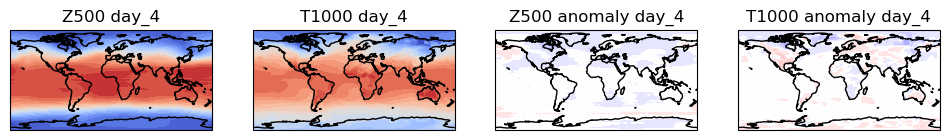

day 5


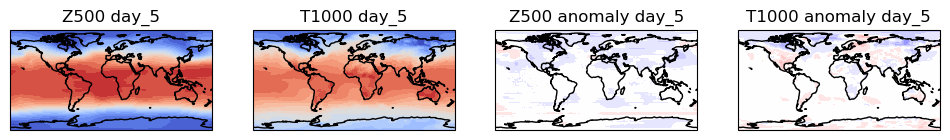

day 6


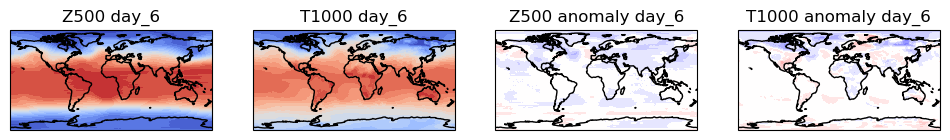

day 7


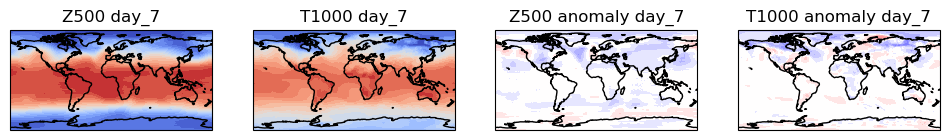

day 8


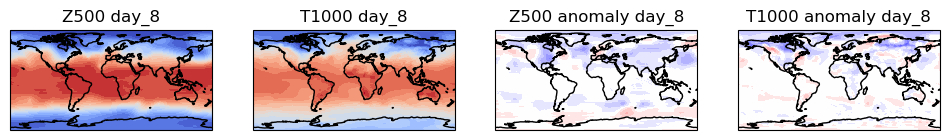

day 9


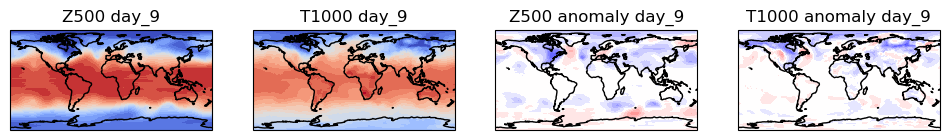

day 10


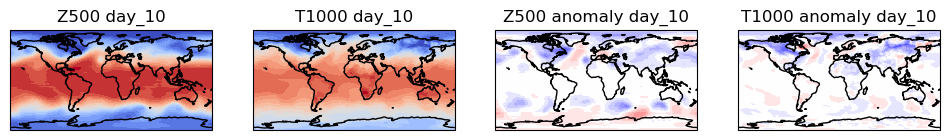

day 11


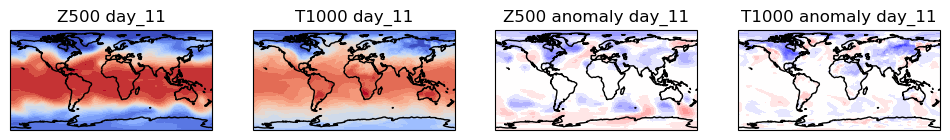

day 12


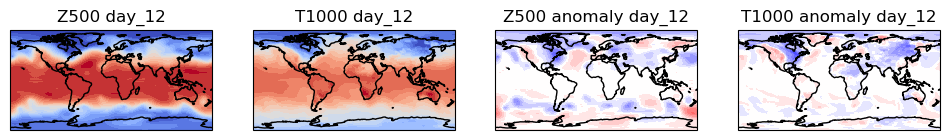

day 13


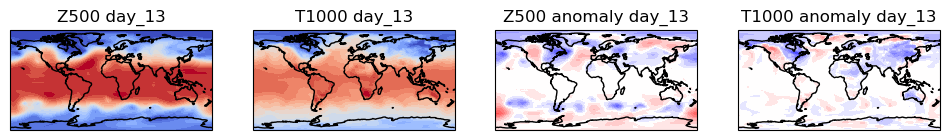

day 14


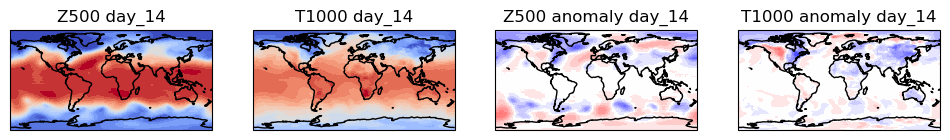

day 15


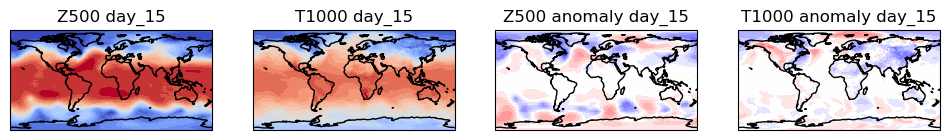

day 16


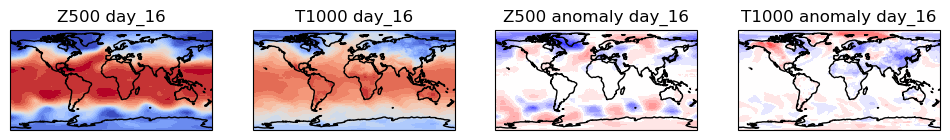

day 17


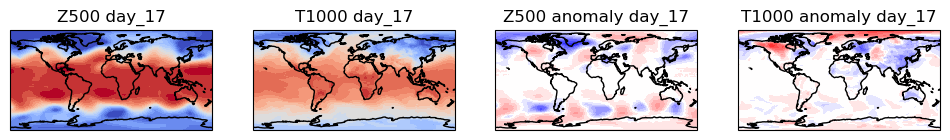

day 18


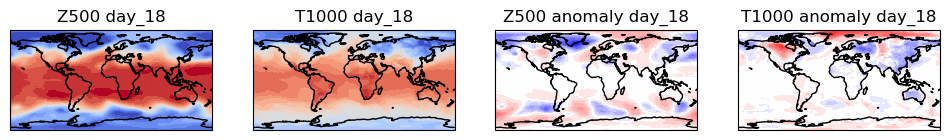

day 19


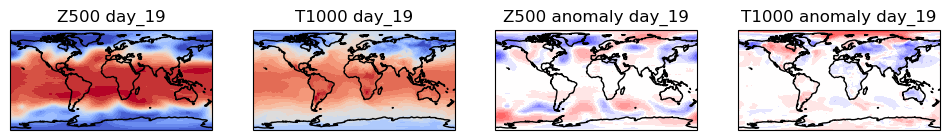

day 20


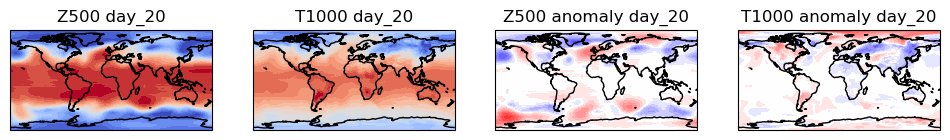

day 21


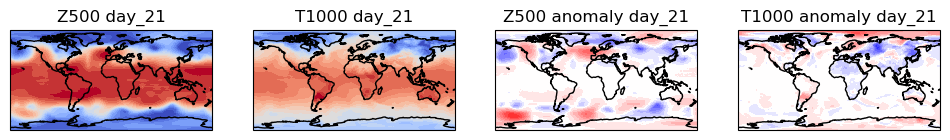

day 22


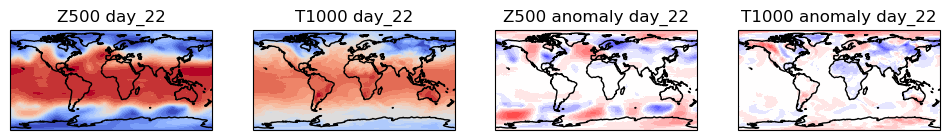

day 23


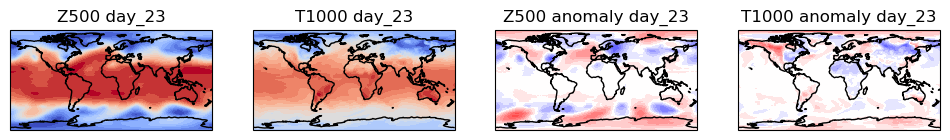

day 24


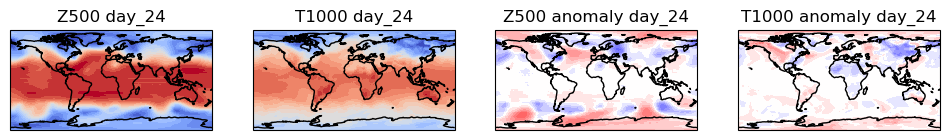

day 25


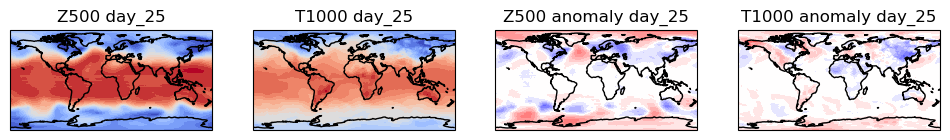

day 26


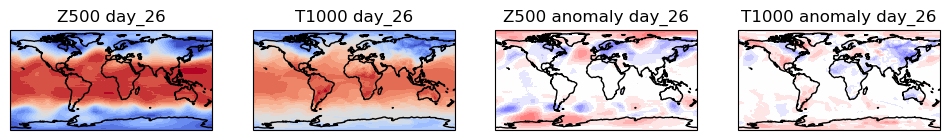

day 27


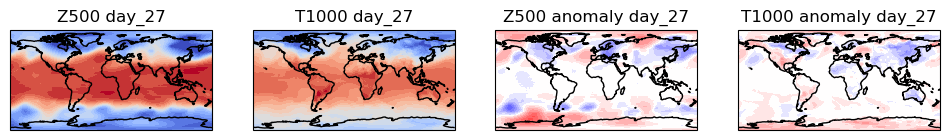

day 28


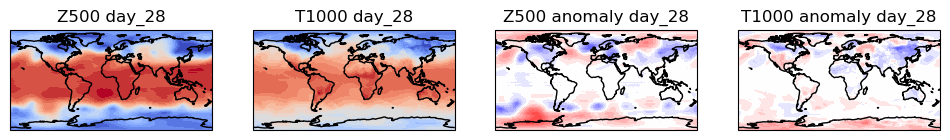

day 29


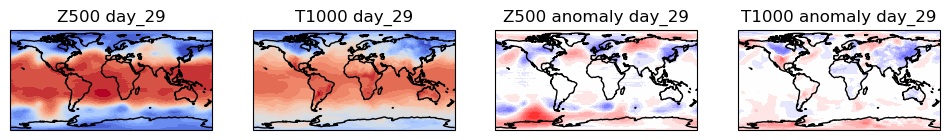

day 30


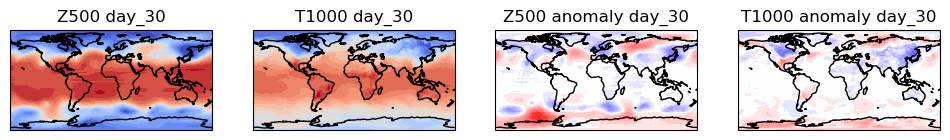

day 31


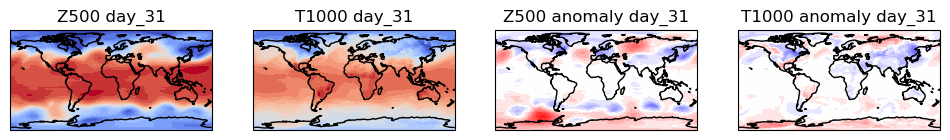

day 32


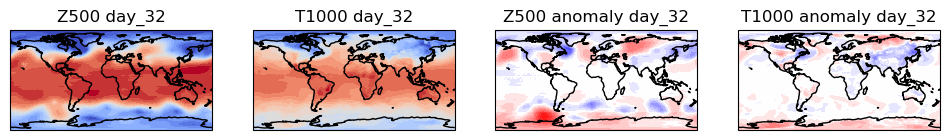

day 33


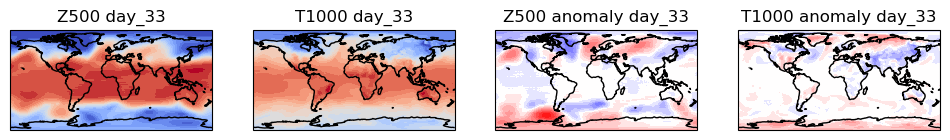

day 34


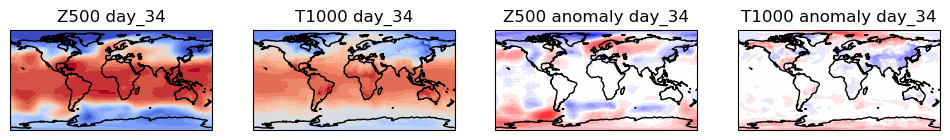

day 35


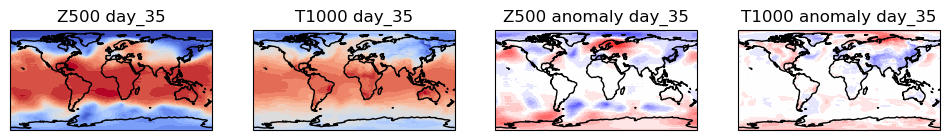

day 36


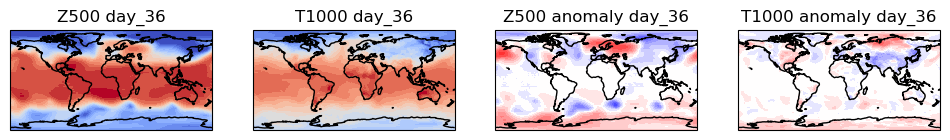

day 37


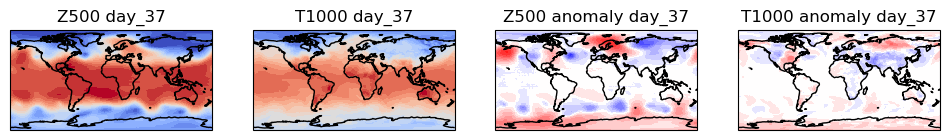

day 38


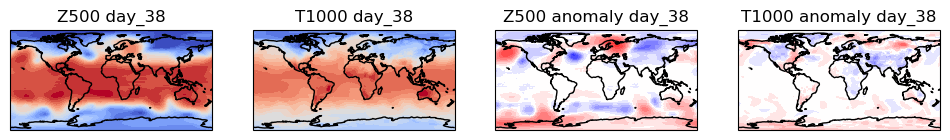

day 39


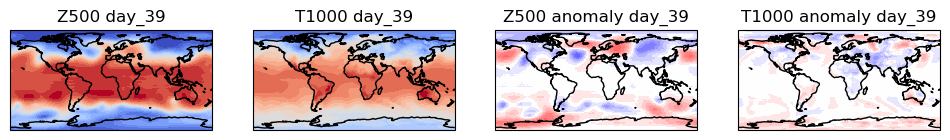

day 40


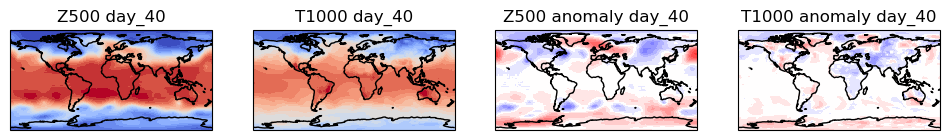

day 41


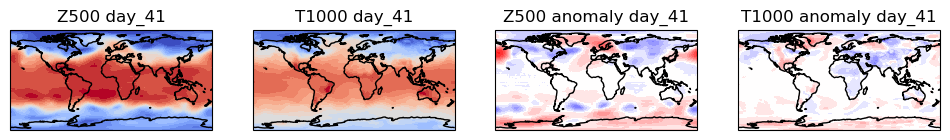

day 42


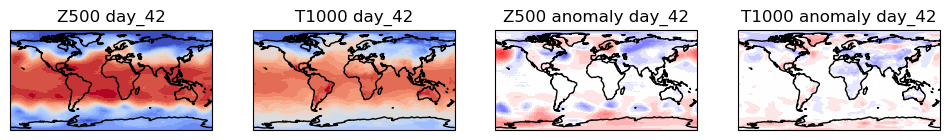

day 43


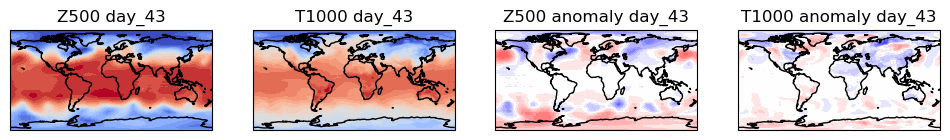

day 44


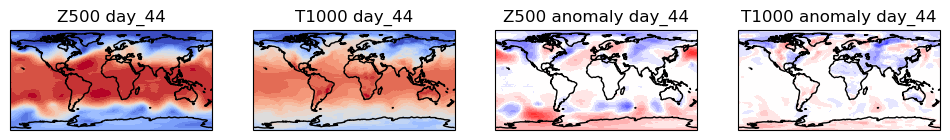

day 45


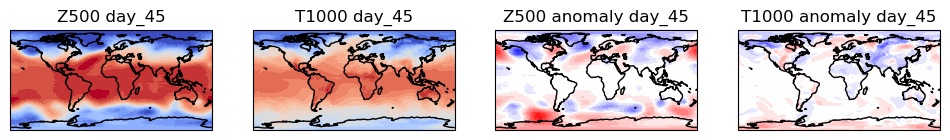

day 46


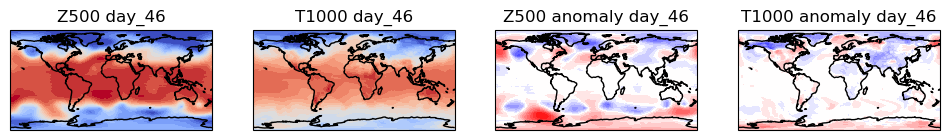

day 47


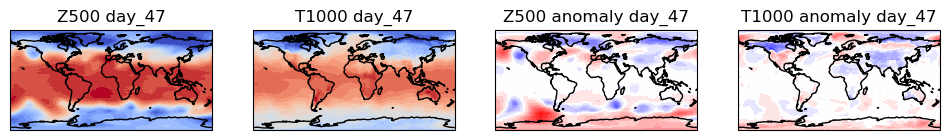

day 48


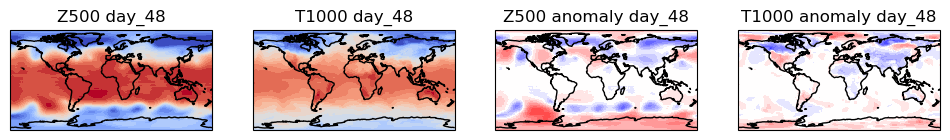

day 49


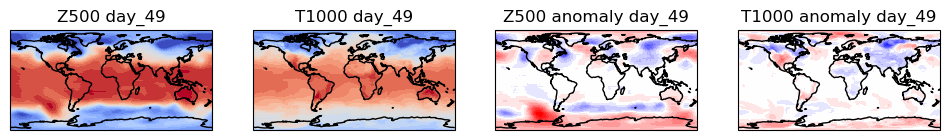

day 50


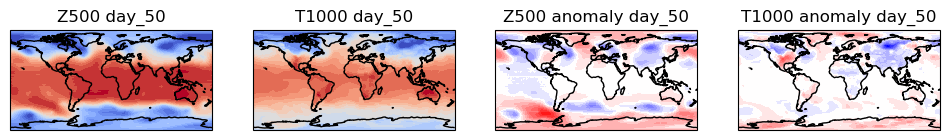

day 51


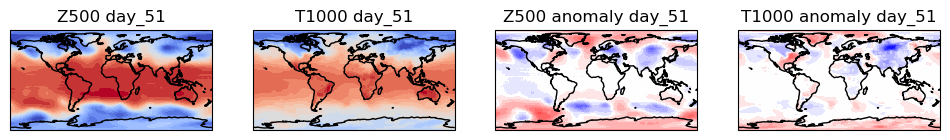

day 52


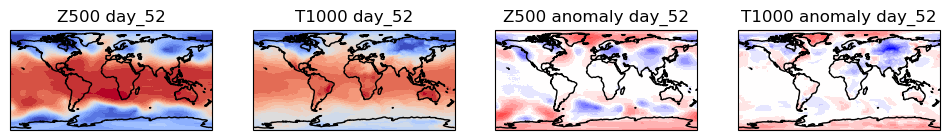

day 53


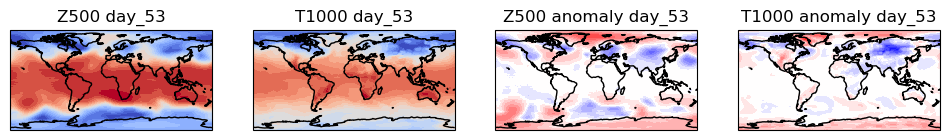

day 54


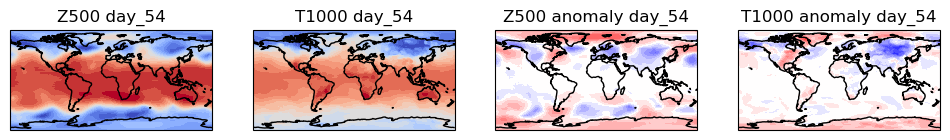

day 55


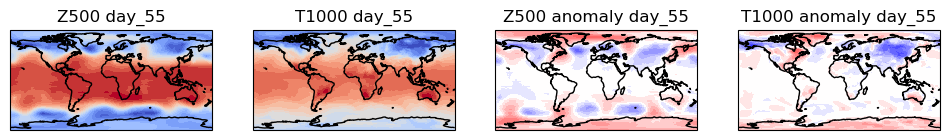

day 56


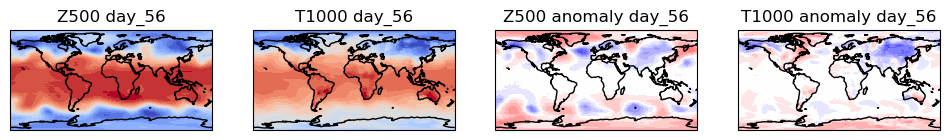

day 57


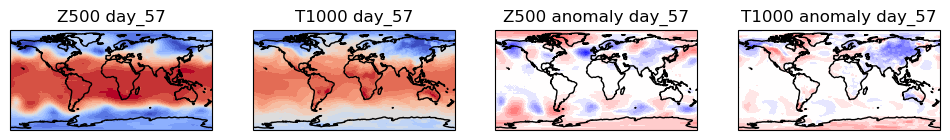

day 58


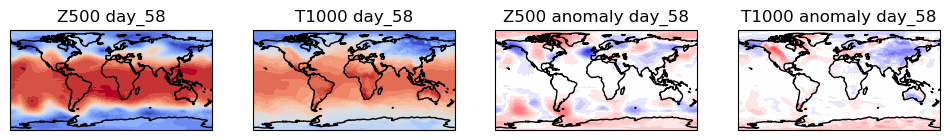

day 59


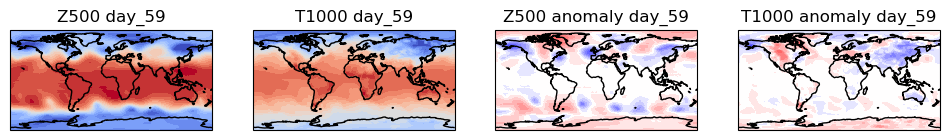

In [3]:
vmin_z, vmax_z = z500_climo.isel(time=0).min().values, z500_climo.isel(time=0).max().values
vmin_t, vmax_t = t1000_climo.isel(time=0).min().values, t1000_climo.isel(time=0).max().values

z_a = (z500_climo - z500_climo.isel(time=0))/z500_climo.isel(time=0)
t_a = (t1000_climo - t1000_climo.isel(time=0))/t1000_climo.isel(time=0)


for i in range(60):
    print(f'day {i}')
    z = z500_climo.isel(time=i)
    t = t1000_climo.isel(time=i)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_ngcm = z.plot.contourf(ax=axes[0], cmap="coolwarm", x='longitude', y='latitude', 
                                     levels=20, vmin=vmin_z, vmax=vmax_z, add_colorbar=False, extend='both', transform=ccrs.PlateCarree())
    axes[0].set_title(f'Z500 day_{i}')
    axes[0].coastlines()

    plot_era = t.plot.contourf(ax=axes[1], cmap="coolwarm", x='longitude', y='latitude',  
                                   levels=20, vmin=vmin_t, vmax=vmax_t, add_colorbar=False, extend='both', transform=ccrs.PlateCarree())
    axes[1].set_title(f'T1000 day_{i}')
    axes[1].coastlines()

    plot_ngcm = z_a.isel(time=i).plot.contourf(ax=axes[2], cmap="bwr", x='longitude', y='latitude', 
                                     levels=20, vmin=-0.1, vmax=0.1, add_colorbar=False, extend='both', transform=ccrs.PlateCarree())
    axes[2].set_title(f'Z500 anomaly day_{i}')
    axes[2].coastlines()

    plot_era = t_a.isel(time=i).plot.contourf(ax=axes[3], cmap="bwr", x='longitude', y='latitude',  
                                   levels=20, vmin=-0.1, vmax=0.1, add_colorbar=False, extend='both', transform=ccrs.PlateCarree())
    axes[3].set_title(f'T1000 anomaly day_{i}')
    axes[3].coastlines()

    # cbar = fig.colorbar(plot_ngcm, ax=axes, orientation="horizontal", fraction=0.06, pad=0.1)
    # cbar.locator = matplotlib.ticker.MaxNLocator(nbins=5) 
    # cbar.update_ticks()
    plt.show()



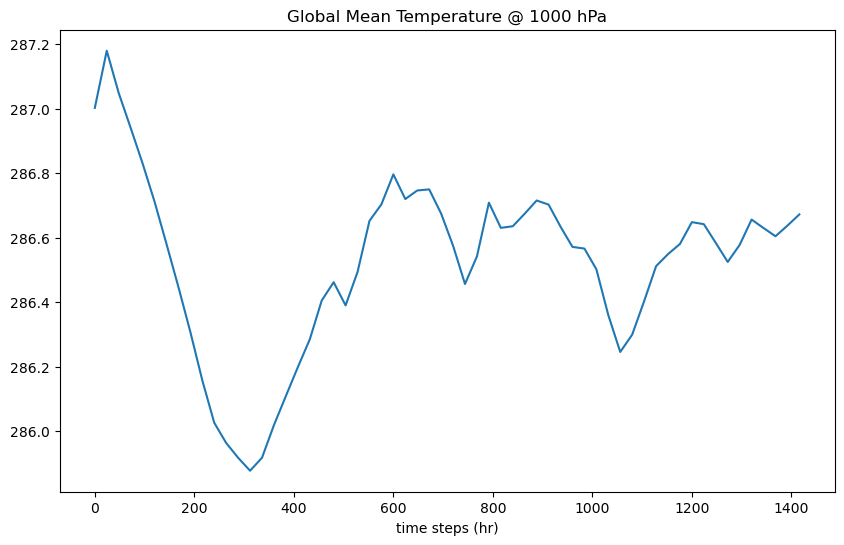

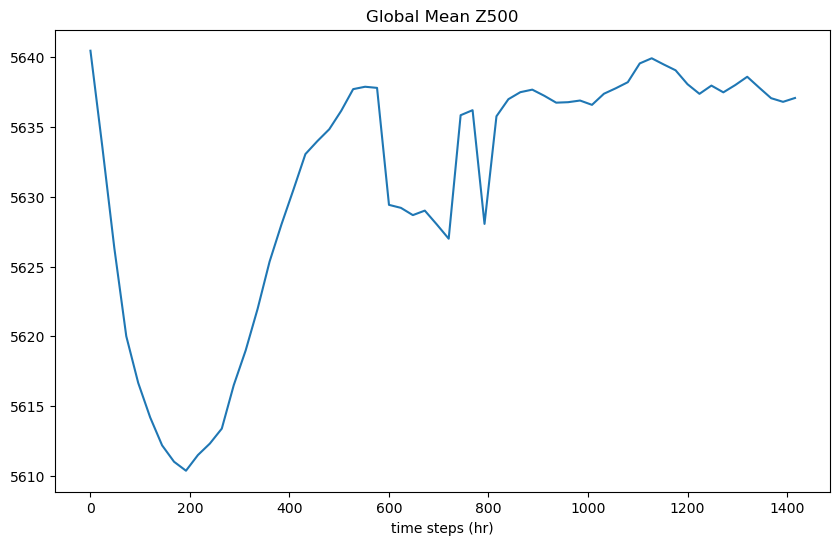

In [7]:
# time series of temperature and geopotential height
def cal_global_mean(da):
    weights = np.cos(np.deg2rad(da.latitude))
    weights /= weights.mean()
    v_g = (da * weights).mean(dim=['latitude', 'longitude'])
    return v_g

z500_climo_g = cal_global_mean(z500_climo)
t1000_climo_g = cal_global_mean(t1000_climo)

plt.figure(figsize=(10, 6))
t1000_climo_g.plot()
plt.title('Global Mean Temperature @ 1000 hPa')
plt.xlabel('time steps (hr)')
plt.show()

plt.figure(figsize=(10, 6))
z500_climo_g.plot()
plt.title('Global Mean Z500')
plt.xlabel('time steps (hr)')
plt.show()

## Part2: 1K at day 0

In [8]:
fpath_d0 = '../output/idealized_T/'
fname_d0 = 'output_MJO_P3_1K_day0_NDJF-climo_day0-24_1-4-deg-model.nc'
ds = xr.open_dataset(fpath_d0 + fname_d0)

z500_d0 = ds.geopotential.sel(level=500) / 9.8
t1000_d0 = ds.temperature.sel(level=1000)

In [60]:
def delta_T_MJO_P3(lat, lon, plev, A=1):
    '''
    calculate MJO phase 3 idealized temperature perturbation
    A: peak heating rate at 0.35 sigma level
    '''
    # parameters for MJO phase 3
    lon_1 = 90 # center of forcing 1
    lon_2 = 170 # center of forcing 2
    #lat_1, lat_2 = 0
    
    lon_scale = 30 # longitude scale; 0.2*A at 50ºE
    lat_scale = 12 # latitude scale; ~0.2*A at 15ºN

    # vertical spread
    P0 = 1000.0 # set surface plev
    v_sprd_max = 0.57923
    sigma = plev / P0
    v_sprd = (1 - sigma) * np.sin( np.pi * (1 - sigma) ) / v_sprd_max

    # horizontal spread
    lat_sprd = np.exp(-1 * (lat/lat_scale)**2)
    term1 = np.exp(-1 * ((lon - lon_1)/lon_scale)**2)
    # term2 = np.exp(-1 * ((lon - lon_2)/lon_scale)**2)
    # h_sprd = np.exp(-1 * (lat/lat_scale)**2) * (term1 - term2)
    h_sprd = np.exp(-1 * (lat/lat_scale)**2) * term1

    h_sprd = h_sprd.where(np.abs(h_sprd) >=0.1, np.nan)


    # pert
    delta_T =  A * v_sprd * h_sprd
    return delta_T

def plot_heating_map(ax, lat, lon, A=1.0):

    plev = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
    plev = xr.DataArray(plev,
                        coords = dict(plev=plev),
                        attrs=dict(
                            long_name = 'pressure level', 
                            units = 'hPa'
                        ))
    
    d_T = delta_T_MJO_P3(lat, lon, plev, A=1.0)

    ax.coastlines()
    # ax.gridlines(draw_labels=True)

    contour_levels = list(np.arange(-1*A, 1.001 *A, A/10))

    contour = ax.contourf(d_T.longitude, d_T.latitude, d_T.sel(plev=300), transform=ccrs.PlateCarree(), 
                        cmap='RdBu_r', extend='neither', levels=contour_levels, vmin=-1*A, vmax=1.01 *A)

    # Add a color bar
    cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, aspect=20, shrink=0.6, label='K')
    cbar.ax.tick_params(labelsize=10)

    # Set the title
    ax.set_title("(a) Heating anomaly", loc='center', fontsize=15)

def plot_heating_vertical_profile(ax, lat, lon, A=1.0):

    plev = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
    plev = xr.DataArray(plev,
                        coords = dict(plev=plev),
                        attrs=dict(
                            long_name = 'pressure level', 
                            units = 'hPa'
                        ))
    d_T = delta_T_MJO_P3(lat, lon, plev, A=1.0)
    d_T_max = d_T.sel(latitude=0, longitude=90, method='nearest')

    ax.plot(d_T_max, d_T.plev, linewidth=2, c= 'k')
    ax.invert_yaxis()
    ax.set_yticks(d_T_max.plev)
    ax.set_xlabel('K', fontsize=10)
    ax.set_ylabel('Pressure level (hPa)', fontsize=10)
    ax.set_title('(b) Vertical Profile', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=10)

In [58]:
def plot_z500(fig, ax, z500, title, vlim=0, add_heating_loc=True):
        
    ax.set_global()
    ax.coastlines()
    # ax.gridlines(draw_labels=True)

    ax.set_title('')
    ax.set_title(title, loc='center', fontsize=15)

    #=====  set colorbar limits =====#
    if vlim == 0:
        if z500.latitude[0] < -45:
            vmax = round(float(z500.sel(latitude=slice(-60, 60)).max()) * 1.2)
        else:
            vmax = round(float(z500.sel(latitude=slice(60, -60)).max()) * 1.2)
        vmin = -1*vmax
    else:
        vmax = vlim
        vmin = -1.0 * vmax
    contour_levels = list(np.arange(vmin, vmax*1.01, vmax/20))

    cmap = plt.get_cmap('bwr', 256)
    #===== plot contourf =====#
    contour = ax.contourf(z500.longitude, z500.latitude, z500,  transform=ccrs.PlateCarree(),
                          cmap=cmap, extend='both', levels=contour_levels, vmin=vmin, vmax=vmax)

    #===== add individual colorbar =====#   
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, aspect=20, shrink=0.6, label='m')
    cbar.ax.tick_params(labelsize=10)
    cbar.locator = LinearLocator(numticks=5)  # You can change nbins to 4, 6, etc.
    cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # or '%.0f' for integers
    cbar.update_ticks() 

    #===== add heating loc =====#
    if add_heating_loc == True:
        lat_scale = 15  # Latitude scale (semi-minor axis)
        lon_scale = 40  # Longitude scale (semi-major axis)
        lon_c = 90
        lat_c = 0
        ellipse = patches.Ellipse((lon_c, lat_c), width=lon_scale*2, height=lat_scale*2, 
                                    edgecolor='r', facecolor='none', linestyle='--', lw=2, transform=ccrs.PlateCarree())
        ax.add_patch(ellipse)  



def plot_panel(z500_diff, climo, model_name, case, vlims=False, add_heating_loc=True, plot_heating=True, fig_name=False):
    #========== plot t2m diff ==========#
    # Set up the map projection (PlateCarree centered at 180° longitude)
    # proj = ccrs.PlateCarree(central_longitude=180)
    proj = ccrs.Robinson(central_longitude=180) 
    if plot_heating:
        fig, axes = plt.subplots(3, 2, figsize=(10, 10), subplot_kw={'projection': proj})
    else:
        fig, axes = plt.subplots(2, 2, figsize=(10, 6.67), subplot_kw={'projection': proj},)

    panel_num = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ', ]

    count_wk = 0

    for i, ax in enumerate(axes.flat):
        print(i)
        
        #===== plot heating schematic =====#
        if i == 0 and plot_heating:
            print('plot heating')
            lat = climo.latitude
            lon = climo.longitude
            plot_heating_map(ax, lat, lon, A=1.0)
        
        elif i == 1 and plot_heating:
            print('plot heating vertical profile')
            fig.delaxes(ax)
            ax = fig.add_subplot(3, 2, i + 1)  # i + 1 is the subplot index (1-based)
            axes.flat[i] = ax  # replace in array to preserve consistency
            box = ax.get_position()
            new_width = box.width * 0.6
            new_height = box.height * 0.85
            new_x = box.x0 + (box.width - new_width) *0.5
            new_y = box.y0 + (box.height - new_height)
            new_box = Bbox.from_bounds(new_x, new_y, new_width, new_height)
            ax.set_position(new_box)

            lat = climo.latitude
            lon = climo.longitude
            plot_heating_vertical_profile(ax, lat, lon, A=1.0)

        else:
            
            ax.set_global()
            ax.coastlines()
            # ax.gridlines(draw_labels=True)

            #===== set title =====#
            if count_wk == 0:
                title = rf'{panel_num[i]} $\mathbf{{{model_name}}}$: Week 1'
            else:
                title = f'{panel_num[i]} Week {count_wk+1}' 
    
            #===== plot z550a =====#
            v_temp = z500_diff.sel(time=slice(7*count_wk+1, 7*(count_wk+1)+1)).mean(dim='time')
            vlim = vlims[count_wk] if vlims else 0
            
            plot_z500(fig, ax, v_temp, title, vlim=vlim, add_heating_loc=add_heating_loc)
            count_wk += 1

    #===== save to png =====#
    if fig_name:

        print(f'saving figure to {fig_name}')
        
        #===== adjust brightness =====#
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=400)
        buf.seek(0)
        image = Image.open(buf).convert('RGB')
        bright_image = Image.eval(image, lambda x: min(int(x * 1.07), 255))  # 1.2 = brighten factor
        plt.figure(figsize=(20, 10))
        plt.imshow(bright_image)
        plt.axis('off')

        save_path = '/barnes-engr-scratch1/dcr17/PROJ_DLWP_and_MJO-teleconnection/analy/figs'
        plt.savefig(f'{save_path}/{fig_name}.png', dpi=400)  # Save as PNG with 300 DPI
        plt.show()

    else:

        plt.suptitle(case, fontsize=15)
        plt.show()

0
plot heating
1
plot heating vertical profile
2
3
4
5
saving figure to Fig_S4


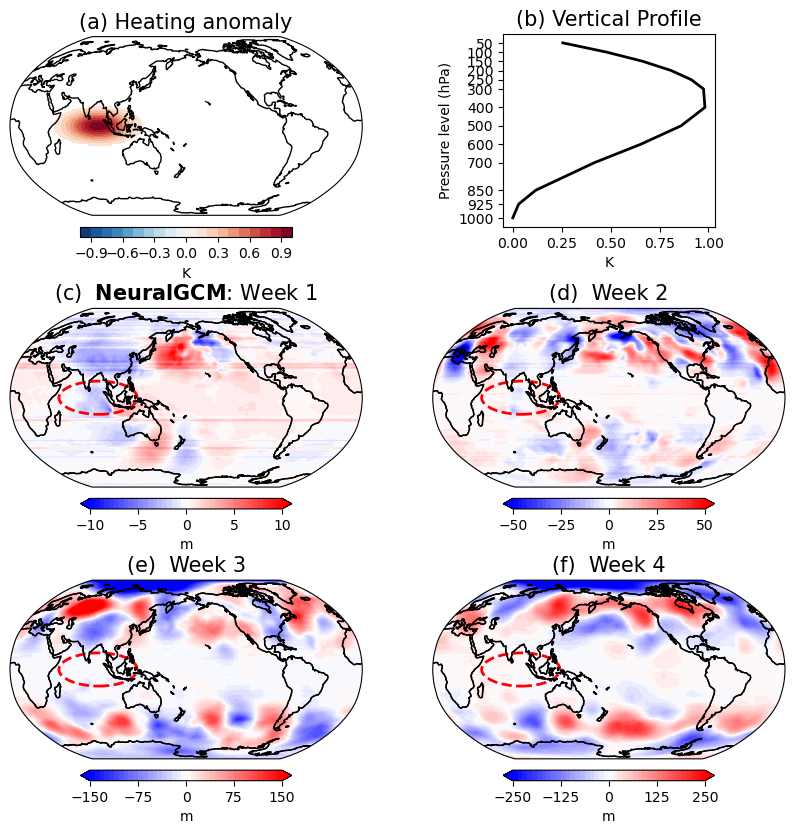

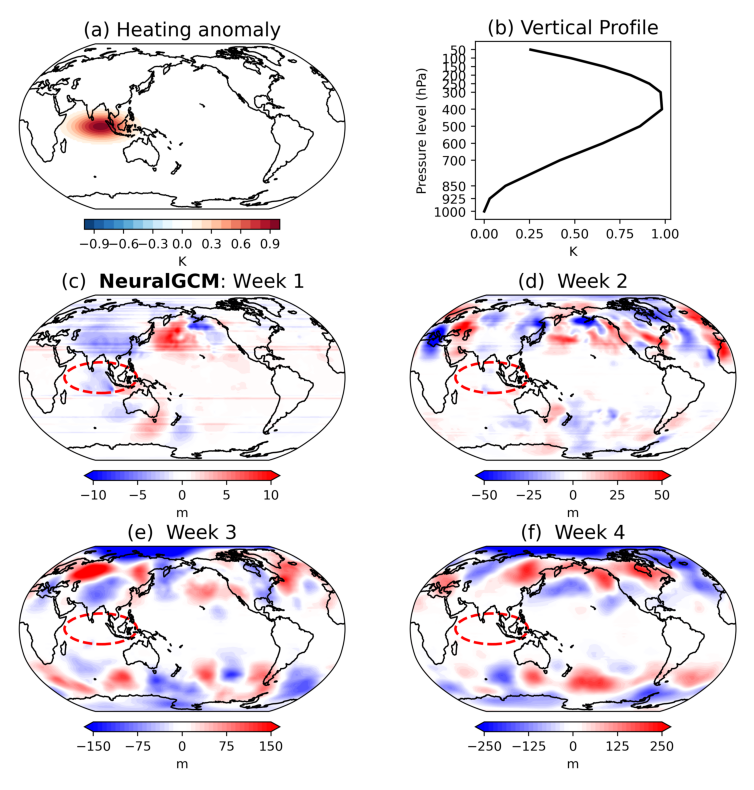

In [61]:
exp_name = 'P3_pert_1K_steady_NDJF-climo'
diff = (z500_d0 - z500_climo).transpose('time', 'latitude', 'longitude')
diff = diff.assign_coords({'time': np.arange(0, len(diff.time), 1)}) # convert to days in time coord

plot_panel(diff,  z500_climo, 'NeuralGCM', exp_name, vlims=[10, 50, 150, 250], add_heating_loc=True, plot_heating=True, fig_name='Fig_S4')
